In [23]:
import numpy as np
import pandas as pd

import scipy.stats

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 20})

model_colors = {'DNABERT':"#D55E00",'DNABERT-3UTR':"#ffac6a", 
                'DNABERT2':"#3F3B6C",'DNABERT2-3UTR':"#adaad0",
                '13-mer':"#CC79A7",
                'PhyloP-241way':"#ffd373",
                'PhyloP-100way':"#e69f00",
                'StateSpace':"#0072B2", 'StateSpace-SA':"#59c3ff", 
                'NTv2-250M':"#009E73", 'NTv2-250M-3UTR':"#00dea2"}

#model_colors = {'DNABERT':"#A3C7D6",'DNABERT-3UTR':"#9F73AB", 
#                'DNABERT2':"#A3C7D6",'DNABERT2-3UTR':"#9F73AB", 
#                '13-mer':"#624F82",
#                'PhyloP-241way':"#3F3B6C",
#                'PhyloP-100way':"#A6D854",
#                'StateSpace':"#E5C494", 'StateSpace-SA':"#FC8D62", 
#                'NTv2-250M':"#999999", 'NTv2-250M-3UTR':"#FCCDE5"}

In [24]:
#10th and 90th percentiles 

percentiles_pref = {"StateSpace":[0.162,0.605],"StateSpace-SA":[0.164,0.587],"DNABERT":[0.16,0.692],"DNABERT-3UTR":[0.157,0.563],"13-mer":[0.113,0.632],"NTv2-250M":[0.132,0.743],"NTv2-250M-3UTR":[0.167,0.426],"PhyloP-100way":[-0.885,2.02],"PhyloP-241way":[-0.915,3.01],}
percentiles_palt_inv = {"StateSpace":[0.934,3.23],"StateSpace-SA":[0.955,3.1],"DNABERT":[0.916,3.51],"DNABERT-3UTR":[0.904,3.11],"13-mer":[0.807,3.63],"NTv2-250M":[0.949,3.23],"NTv2-250M-3UTR":[1.09,2.07],}
percentiles_ratio = {"StateSpace":[-0.659,2.43],"StateSpace-SA":[-0.63,2.28],"DNABERT":[-0.692,2.79],"DNABERT-3UTR":[-0.729,2.23],"13-mer":[-1.04,3.01],"NTv2-250M":[-0.82,2.62],"NTv2-250M-3UTR":[-0.587,1.05],}

In [25]:
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/mlm/'

In [26]:
utr_variants = pd.read_csv(data_dir + 'variants/model_scores_snp.tsv', sep='\t')

utr_variants.groupby('split').label.value_counts()

split       label
clinvar     0.0      10000
            1.0        249
eQTL-GRASP  0.0      10000
            1.0        751
eQTL-susie  1.0      10000
            0.0      10000
gnomAD      0.0      10000
            1.0      10000
Name: count, dtype: int64

In [27]:
split = 'gnomAD' # clinvar, gnomAD or eQTL
scoring = 'pref' #pref, paltinv, ratio

In [28]:
utr_variants = utr_variants[utr_variants.split==split]

In [29]:
utr_variants.columns

Index(['chrom', 'pos', 'source', 'label', 'ref', 'alt', 'vartype', 'seq_name',
       'seq_start', 'seq_end', 'strand', 'split', 'pos_rel',
       'PhyloP-100way-pref', 'PhyloP-241way-pref', 'StateSpace-palt',
       'StateSpace-pref', 'StateSpace-SA-palt', 'StateSpace-SA-pref',
       'DNABERT-palt', 'DNABERT-pref', 'DNABERT-3UTR-palt',
       'DNABERT-3UTR-pref', '13-mer-palt', '13-mer-pref', 'NTv2-250M-palt',
       'NTv2-250M-pref', 'NTv2-250M-3UTR-palt', 'NTv2-250M-3UTR-pref',
       'StateSpace-l1', 'StateSpace-l2', 'StateSpace-dot', 'StateSpace-cosine',
       'StateSpace-loss_ref', 'StateSpace-loss_alt', 'StateSpace-SA-l1',
       'StateSpace-SA-l2', 'StateSpace-SA-dot', 'StateSpace-SA-cosine',
       'StateSpace-SA-loss_ref', 'StateSpace-SA-loss_alt', 'DNABERT2-l1',
       'DNABERT2-l2', 'DNABERT2-dot', 'DNABERT2-cosine', 'DNABERT2-loss_ref',
       'DNABERT2-loss_alt', 'DNABERT2-3UTR-l1', 'DNABERT2-3UTR-l2',
       'DNABERT2-3UTR-dot', 'DNABERT2-3UTR-cosine', 'DNABERT2-3UTR-l

In [30]:
def get_contig_table(model):

    if scoring=='pref':
        score = utr_variants[f'{model}-pref']
        perc_low, perc_high = percentiles_pref[model]
    elif scoring=='ratio':
        score = np.log(utr_variants[f'{model}-pref']/utr_variants[f'{model}-palt'])
        perc_low, perc_high = percentiles_ratio[model]
    elif scoring=='paltinv':
        score = np.log(1/utr_variants[f'{model}-palt'])
        perc_low, perc_high = percentiles_palt_inv[model]         
            
    pathogenic_bottom = ((score<perc_low)&(utr_variants.label==1)).sum()
    pathogenic_top = ((score>perc_high)&(utr_variants.label==1)).sum()
    
    benign_bottom = ((score<perc_low)&(utr_variants.label==0)).sum()
    benign_top = ((score>perc_high)&(utr_variants.label==0)).sum()

    contig_table = [[pathogenic_top,benign_top], [pathogenic_bottom,benign_bottom] ]

    return contig_table, score

In [31]:
models = ('DNABERT','DNABERT-3UTR', 'NTv2-250M','NTv2-250M-3UTR', 'StateSpace', 'StateSpace-SA','13-mer', 'PhyloP-100way', 'PhyloP-241way', )

In [32]:
odds_ratios = []
score = {}

for model in models:
    
    contig_table, score[model] = get_contig_table(model)
    fisher_test = scipy.stats.fisher_exact(contig_table)
        
    print(model,contig_table, fisher_test)

    OR = fisher_test.statistic
    CI_95_high = np.exp(np.log(OR)+1.96*np.sqrt((1/np.array(contig_table)).sum()))
    CI_95_low = np.exp(np.log(OR)-1.96*np.sqrt((1/np.array(contig_table)).sum()))

    odds_ratios.append((model, fisher_test.statistic,CI_95_low, CI_95_high,fisher_test.pvalue))

odds_ratios = pd.DataFrame(odds_ratios,columns=['model','OR', 'CI_95_low','CI_95_high', 'pvalue'])#.sort_values(by='OR', ascending=False)
odds_ratios['padj'] = odds_ratios.pvalue*len(models)
odds_ratios.set_index('model', inplace=True)

DNABERT [[961, 900], [1344, 2629]] SignificanceResult(statistic=2.0886813822751322, pvalue=4.840235077231239e-38)
DNABERT-3UTR [[960, 970], [1425, 2625]] SignificanceResult(statistic=1.8231144872490506, pvalue=1.2955156141153647e-26)
NTv2-250M [[938, 877], [1138, 1741]] SignificanceResult(statistic=1.6362880325763056, pvalue=3.480960993738263e-16)
NTv2-250M-3UTR [[993, 1106], [1197, 1727]] SignificanceResult(statistic=1.295365447977992, pvalue=7.736648494590059e-06)
StateSpace [[954, 931], [1399, 2633]] SignificanceResult(statistic=1.9285541536881108, pvalue=5.032461250030747e-31)
StateSpace-SA [[965, 910], [1416, 2631]] SignificanceResult(statistic=1.970350623952319, pvalue=6.39752780610016e-33)
13-mer [[892, 765], [1251, 2195]] SignificanceResult(statistic=2.0458822484496064, pvalue=2.871390061572416e-32)
PhyloP-100way [[884, 311], [1198, 2443]] SignificanceResult(statistic=5.796402364068732, pvalue=3.5381072320593776e-138)
PhyloP-241way [[948, 428], [1067, 1528]] SignificanceResult(

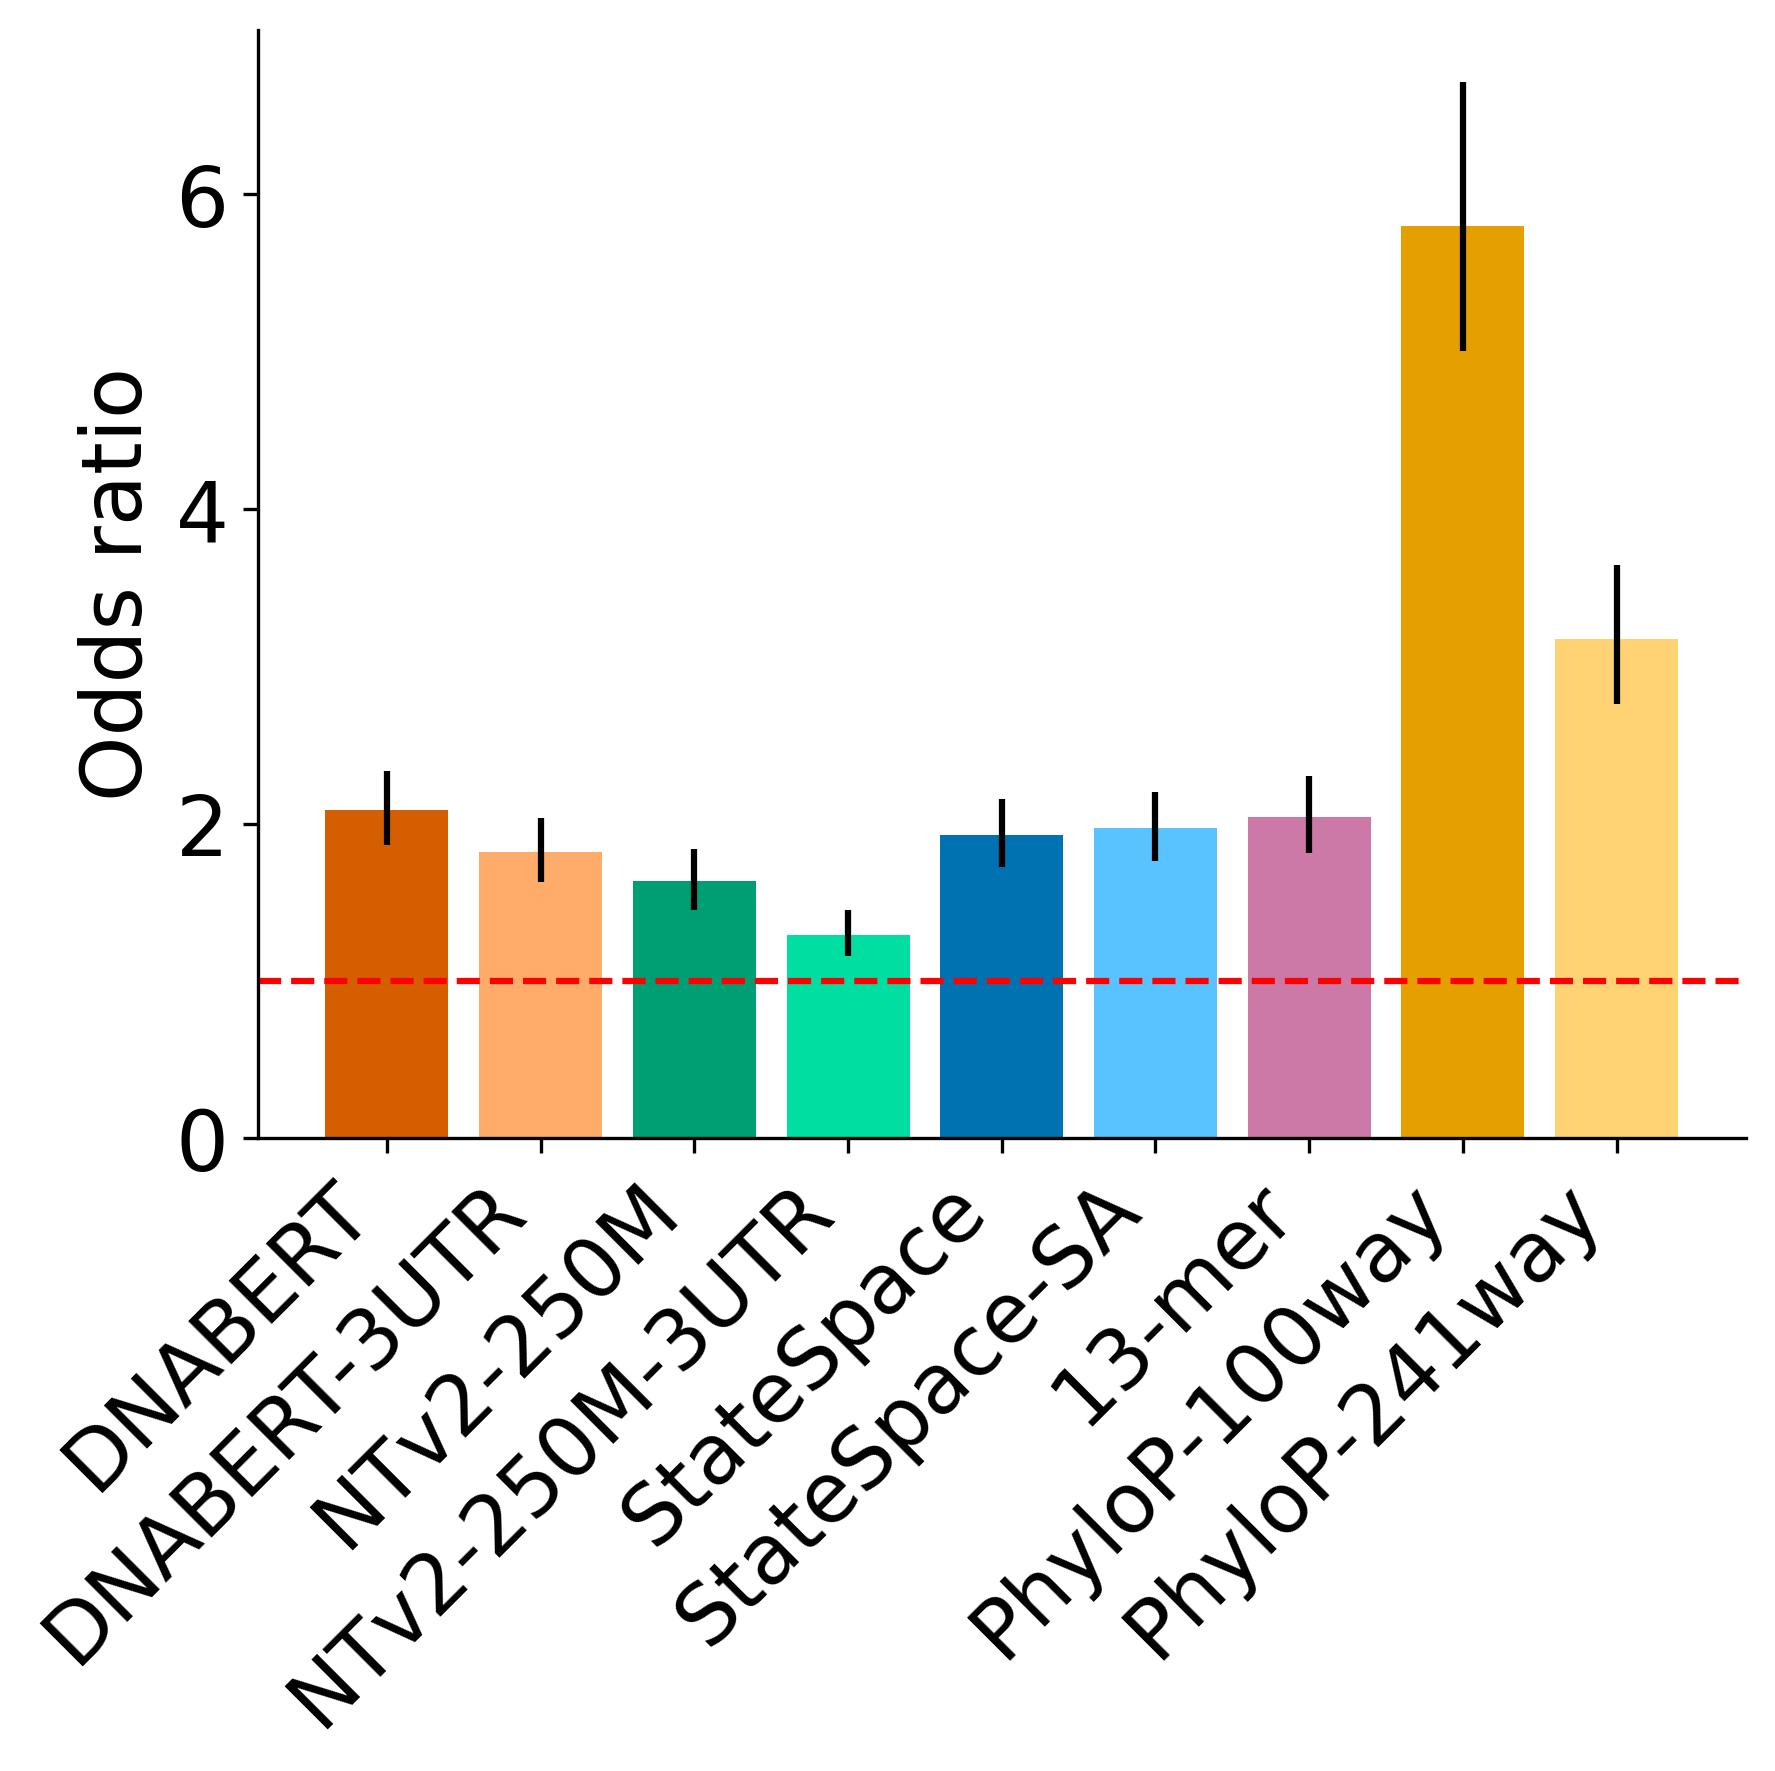

In [33]:
fig, ax = plt.subplots(dpi=300)

ax.bar(odds_ratios.index, odds_ratios.OR, yerr=[odds_ratios.OR-odds_ratios.CI_95_low,odds_ratios.CI_95_high-odds_ratios.OR], color=odds_ratios.index.map(model_colors))
plt.xticks(rotation=45, ha="right")
ax.set_ylabel('Odds ratio')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

if odds_ratios.OR.max()>50:
    ax.set_yscale('log')

ax.axhline(1,0,len(models),color='r', linestyle='--')

for model_idx, model in enumerate(odds_ratios.index):
    padj = odds_ratios.loc[model,'padj']
    if padj<1e-4:
        stars='****'
    elif padj<1e-3:
        stars='***'
    elif padj<1e-2:
        stars = '**'
    elif padj<5e-2:
        stars = '*'
    else:
        stars = 'ns'
    #ax.text(model_idx, odds_ratios.loc[model].OR+odds_ratios.OR.max()*0.03, f'{stars}',ha='center', va='center')
    #ax.text(model_idx, odds_ratios.loc[model].OR*1.3, f'{stars}',ha='center', va='center')
#ax.set_ylim([0,260])